# 5. Running a full analysis

*Written by Jin Hyun Cheong and Eshin Jolly*

In this tutorial we'll perform a real analysis on the dataset from ["A Data-Driven Characterisation Of Natural Facial Expressions When Giving Good And Bad News"](https://journals.plos.org/ploscompbiol/article/peerReview?id=10.1371/journal.pcbi.1008335) by Watson & Johnston 2020.  You can try it out interactively in Google Collab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cosanlab/py-feat/blob/master/notebooks/content/04_fex_analysis.ipynb)

In this analysis, we'll explore any differences in facial expressions people made when receiving good or bad news (see the original paper for more details). The full dataset is available on [OSF](https://osf.io/6tbwj/), so we'll first download the videos and their metadata. Then, we'll load up some pre-trained emotion and action-unit (AU) detectors and use them to extract AU intensity from the videos in the dataset. Finally, we'll demonstrate how easy it is to perform several different kinds of comparisons acoss experimental conditions (good vs bad) using the `Fex` data class.


In [ ]:
# Uncomment the line below and run this only if you're using Google Collab
# !pip install -q py-feat

## 5.1 Download the data

First we'll need to download all 20 video files and their corresponding attributes CSV files from OSF. The next cell should run quickly on Google Collab, but will depend on your own internet conection if you're executing this notebook locally. You can rerun this cell in case the download fails for any reason, as it should skip downloading existing files:

In [1]:
import os
import glob
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")

files_to_download = {
    "4c5mb": 'clip_attrs.csv',
    "n6rt3": '001.mp4',
    "3gh8v": '002.mp4',
    "twqxs": '003.mp4',
    "nc7d9": '004.mp4',
    "nrwcm": '005.mp4',
    "2rk9c": '006.mp4',
    "mxkzq": '007.mp4',
    "c2na7": '008.mp4',
    "wj7zy": '009.mp4',
    "mxywn": '010.mp4',
    "6bn3g": '011.mp4',
    "jkwsp": '012.mp4',
    "54gtv": '013.mp4',
    "c3hpm": '014.mp4',
    "utdqj": '015.mp4',
    "hpw4a": '016.mp4',
    "94swe": '017.mp4',
    "qte5y": '018.mp4',
    "aykvu": '019.mp4',
    "3d5ry": '020.mp4',
}

for fid, fname in files_to_download.items():
    if not os.path.exists(fname):
        subprocess.run(f"wget -O {fname} --content-disposition https://osf.io/{fid}/download".split())
    else:
        print(f'Already downloaded: {fname}')

clip_attrs = pd.read_csv("clip_attrs.csv")
videos = np.sort(glob.glob("*.mp4"))
print(videos)

Already downloaded: clip_attrs.csv
Already downloaded: 001.mp4
Already downloaded: 002.mp4
Already downloaded: 003.mp4
Already downloaded: 004.mp4
Already downloaded: 005.mp4
Already downloaded: 006.mp4
Already downloaded: 007.mp4
Already downloaded: 008.mp4
Already downloaded: 009.mp4
Already downloaded: 010.mp4
Already downloaded: 011.mp4
Already downloaded: 012.mp4
Already downloaded: 013.mp4
Already downloaded: 014.mp4
Already downloaded: 015.mp4
Already downloaded: 016.mp4
Already downloaded: 017.mp4
Already downloaded: 018.mp4
Already downloaded: 019.mp4
Already downloaded: 020.mp4
['001.mp4' '002.mp4' '003.mp4' '004.mp4' '005.mp4' '006.mp4' '007.mp4'
 '008.mp4' '009.mp4' '010.mp4' '011.mp4' '012.mp4' '013.mp4' '014.mp4'
 '015.mp4' '016.mp4' '017.mp4' '018.mp4' '019.mp4' '020.mp4']


## 5.2 Process videos with a Detector

Now we'll initialize a new `Detector` and process each frame of each video, saving the results to csv files named after the video.

In [2]:
from feat import Detector

detector = Detector(au_model = "rf", emotion_model = "resmasknet")

for video in videos: 
    out_name = video.replace(".mp4", ".csv")
    if os.path.exists(out_name):
        print(f"Already processed: {video}")
    else:
        print(f"Processing: {video}")
        detector.detect_video(inputFname = video, outputFname = out_name)

Already processed: 001.mp4
Already processed: 002.mp4
Already processed: 003.mp4
Already processed: 004.mp4
Already processed: 005.mp4
Already processed: 006.mp4
Already processed: 007.mp4
Already processed: 008.mp4
Already processed: 009.mp4
Already processed: 010.mp4
Already processed: 011.mp4
Already processed: 012.mp4
Already processed: 013.mp4
Already processed: 014.mp4
Already processed: 015.mp4
Already processed: 016.mp4
Already processed: 017.mp4
Already processed: 018.mp4
Already processed: 019.mp4
Already processed: 020.mp4


Then we can use `read_feat` to load each CSV file and concatenate them together:

In [3]:
from feat.utils import read_feat
import pandas as pd

for ix ,video in enumerate(videos):
    out_name = video.replace(".mp4", ".csv")
    if ix == 0: 
        fex = read_feat(out_name)
    else:
        fex = pd.concat([fex, read_feat(out_name)])

fex = fex.dropna()
fex.head()

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Roll,Yaw,anger,disgust,fear,happiness,sadness,surprise,neutral,input
0,0,353.55045,284.39127,391.98178,528.90220,0.999796,361.880771,364.289369,370.594672,380.223391,...,-2.339310,1.250120,0.000156,0.000084,0.000831,0.962823,0.001139,0.029125,0.005842,001.csv
1,1,353.57070,284.55023,391.95688,528.65340,0.999795,361.880771,364.289369,370.594672,380.223391,...,-2.339310,1.250120,0.000156,0.000084,0.000831,0.962823,0.001139,0.029125,0.005842,001.csv
2,2,356.05103,284.03060,390.63580,527.54846,0.999777,361.573799,363.808128,370.042310,379.564765,...,-2.135026,1.276191,0.000164,0.000071,0.001515,0.851698,0.000759,0.141473,0.004320,001.csv
3,3,372.93625,282.33966,387.16977,529.44080,0.999792,361.860681,364.592245,371.379240,381.879548,...,-2.460083,1.462515,0.000224,0.000105,0.001229,0.867401,0.000670,0.127383,0.002988,001.csv
4,4,360.22266,280.82220,387.91090,522.95844,0.999802,366.604045,369.182709,375.583051,385.617726,...,-2.483959,1.655841,0.000161,0.000186,0.000778,0.964715,0.001320,0.029267,0.003572,001.csv


Lastly we can match the processed file names to the text that participants heard in the experiment using the attributes file:

In [4]:
# Load in attributes
clip_attrs = pd.read_csv("clip_attrs.csv")

# Add in file names and rename conditions
clip_attrs = clip_attrs.assign(
    input=clip_attrs.clipN.apply(lambda x: str(x).zfill(3) + ".mp4"),
    condition=clip_attrs["class"].replace({"gn": "goodNews", "ists": "badNews"}),
)

clip_attrs.head()

,clipN,class,phraseN,phrase_txt,input,condition
0,1,gn,1,your loan has been approved,001.mp4,goodNews
1,2,gn,2,you've got the job,002.mp4,goodNews
2,3,gn,3,the vendor has accepted your offer,003.mp4,goodNews
3,4,gn,4,your tests have come back clear,004.mp4,goodNews
4,5,gn,5,your application has been accepted,005.mp4,goodNews


## 5.3 Summary statistics and feature extraction

`Fex` data classes have a special attribute called `.sessions` that allow you to more easily compute summary statistics while respecting the grouping of an experimental setup. For example, if we set `.sessions` to the name of each video, then we can easily calculate mean AU intensity separately for each video using `.extract_mean()`.

In [44]:
# Set sessions to the input filenames
fex.sessions = fex['input'].str.replace('.csv', '.mp4')

# Now extracting the mean is grouped by video 
average_au_intensity_per_video = fex.extract_mean()
average_au_intensity_per_video.head()

/var/folders/g3/k36shgps5c75hyl9xhjk3cb80000gn/T/ipykernel_21918/1935388116.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  fex.sessions = fex['input'].str.replace('.csv', '.mp4')
/Users/Esh/Documents/pypackages/py-feat/feat/data.py:1044: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feats.append(pd.Series(v.mean(), name=k))


,mean_frame,mean_FaceRectX,mean_FaceRectY,mean_FaceRectWidth,mean_FaceRectHeight,mean_FaceScore,mean_x_0,mean_x_1,mean_x_2,mean_x_3,...,mean_Pitch,mean_Roll,mean_Yaw,mean_anger,mean_disgust,mean_fear,mean_happiness,mean_sadness,mean_surprise,mean_neutral
001.mp4,15.333333,363.440811,276.011551,389.400380,531.317063,0.999798,363.315102,366.280346,373.149525,383.261043,...,0.177313,-2.114715,1.180729,0.000413,0.000135,0.004354,0.807167,0.002137,0.180481,0.005313
002.mp4,13.500000,357.046632,271.387664,388.206440,534.764812,0.999801,356.668935,359.150546,365.668823,375.458671,...,0.283955,-1.140242,-0.137504,0.000334,0.000193,0.003266,0.689485,0.003445,0.296081,0.007197
003.mp4,23.000000,346.714941,270.177871,386.564368,536.648572,0.999812,350.511296,351.734623,356.819917,365.767994,...,0.338764,-0.764419,-0.115190,0.000173,0.000066,0.003915,0.390239,0.000757,0.602745,0.002105
004.mp4,22.000000,334.102018,280.312059,386.093014,530.022378,0.999812,335.403217,338.709198,345.324274,355.286428,...,1.916862,-2.290477,0.568985,0.000567,0.000201,0.005668,0.657875,0.004872,0.324604,0.006213
005.mp4,22.000000,320.158563,295.608988,386.956427,528.865910,0.999818,321.261506,324.980402,332.101778,342.213722,...,1.006443,-2.907811,0.906388,0.000209,0.000059,0.002261,0.870938,0.001409,0.121527,0.003597


However, you can set `.sessions` to any grouping you desire. For the current analysis, setting `.sessions` equal to the condition each frame belonged to, allows us to easily calculate mean AU intensity per condition using `.extract_mean()`:

In [22]:
clip_attrs.head()

,clipN,class,phraseN,phrase_txt,input,condition
0,1,gn,1,your loan has been approved,001.mp4,goodNews
1,2,gn,2,you've got the job,002.mp4,goodNews
2,3,gn,3,the vendor has accepted your offer,003.mp4,goodNews
3,4,gn,4,your tests have come back clear,004.mp4,goodNews
4,5,gn,5,your application has been accepted,005.mp4,goodNews


In [45]:
# Assign each processed frame to the condition it came from
conditions = dict(zip(clip_attrs['input'], clip_attrs['condition']))
fex.sessions = fex.sessions.map(conditions)

# Now extracting the mean is grouped by session (experimental condition)
average_au_intensity_per_condition = fex.extract_mean()
average_au_intensity_per_condition.head()

/Users/Esh/Documents/pypackages/py-feat/feat/data.py:1044: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feats.append(pd.Series(v.mean(), name=k))


,mean_frame,mean_FaceRectX,mean_FaceRectY,mean_FaceRectWidth,mean_FaceRectHeight,mean_FaceScore,mean_x_0,mean_x_1,mean_x_2,mean_x_3,...,mean_Pitch,mean_Roll,mean_Yaw,mean_anger,mean_disgust,mean_fear,mean_happiness,mean_sadness,mean_surprise,mean_neutral
badNews,28.089720,324.400708,301.247496,391.827660,532.716661,0.999816,322.016527,328.383112,339.664185,355.110626,...,-5.782593,-3.816183,-2.723817,0.020171,0.014992,0.097006,0.013134,0.086385,0.697528,0.070784
goodNews,20.646766,340.821428,275.474329,387.800142,533.403960,0.999813,341.648032,344.112135,350.285509,359.913069,...,0.752362,-1.497069,-0.174644,0.000287,0.000095,0.004073,0.618644,0.001715,0.371462,0.003724


## 5.4 Evaluting overall AU intensity with a one-sample t-test

One analyses we might be interested in is if the average activation of any AUs are significantly higher than .5 (chance) when participants received good news. We can do this by running a one-sample t-test over the mean AU activity per video using the `.ttest_1samp()` method.

The results suggests more than half the AUs are significantly active beyond chance:

In [39]:
# Set the session of the summary Fe instance to the experiental conditions
average_au_intensity_per_video.sessions = average_au_intensity_per_video.index.map(
    conditions
)

# Then we can perform a test for one condition only
t, p = (
    average_au_intensity_per_video[average_au_intensity_per_video.sessions == 'goodNews']
    .aus
    .ttest_1samp(0.5)
)

# Show significance start based on bonferroni correction
results = pd.DataFrame(
    {"t": t, "p": p}, index=average_au_intensity_per_video.au_columns
).assign(sig=lambda df: df.p < 0.05 / df.shape[0]).sort_values(by='sig')
results


,t,p,sig
mean_AU01,-3.083360,1.306884e-02,False
mean_AU25,3.540150,6.312618e-03,False
mean_AU24,-2.462283,3.602344e-02,False
mean_AU06,3.189709,1.101172e-02,False
mean_AU23,-0.640517,5.378009e-01,False
mean_AU17,0.021491,9.833231e-01,False
mean_AU28,-2.146230,6.040604e-02,False
mean_AU26,-6.413477,1.233055e-04,True
mean_AU20,-19.486802,1.141779e-08,True
mean_AU15,-8.882221,9.508308e-06,True


## 5.5 Comparing conditions

### 5.5.1 Looking at condition ifferences for a single AU using a t-test

More likely we want to compare experimental conditions using a two-sample t-test. This allows us to answer separately for each AU: was intensity significantly different when participants received good vs bad news? We can do this using the `.ttest_ind()` method which takes a column and sessions to compare:  

T-test between goodNews vs badNews: t=15, p=9.63e-12


<AxesSubplot:ylabel='mean_AU12'>

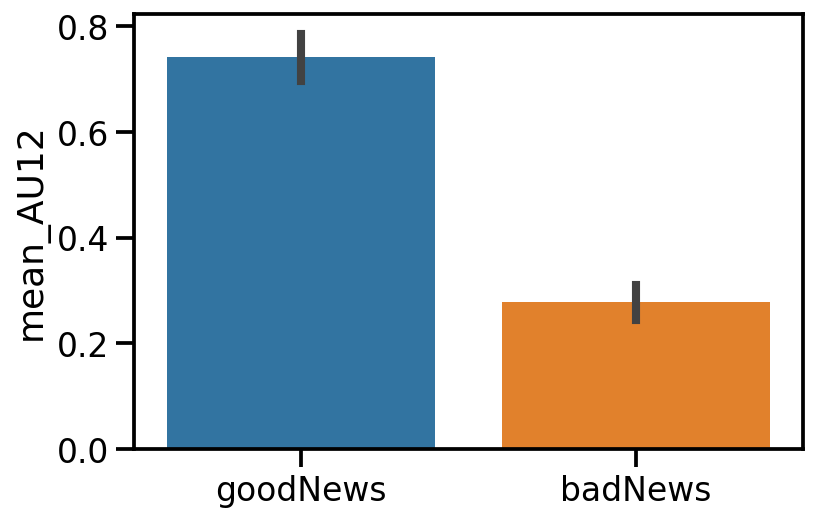

In [40]:
columns2compare = "mean_AU12"
sessions = ("goodNews", "badNews")

t, p = average_au_intensity_per_video.ttest_ind(col=columns2compare, sessions=sessions)
print(f"T-test between {sessions[0]} vs {sessions[1]}: t={t:.2g}, p={p:.3g}")
sns.barplot(
    x=average_au_intensity_per_video.sessions,
    y=columns2compare,
    data=average_au_intensity_per_video,
)


### 5.5.2 Comparing all AUs across conditions using regression

More likely we'll want to run this comparison for *all* AUs. Because t-tests are just regression we can using the `.regress()` method along with numerical contrasts to corresponding to the condition means to run a test at every AU.

This is analogous to the "mass-univariate" GLM approach in fMRI researchnd allows us to identify what AUs are significantly more active in condition vs another:

In [53]:
# This time replace the labels for each condition with a numerical contrast code
# We'll use these contrasts are predictors in our regression
X = pd.DataFrame(fex.sessions.replace({"goodNews": 0.5, "badNews": -0.5}))

# Add an intercept to the regression
X["intercept"] = 1

# The dependent variable is AU intensity
y = fex.aus
# Now we get a t-test at every AU
b, t, p, df, residuals = fex.regress(X=X, y=y)

print("Betas comparing the contrast of good news AU intensity > bad news AU intensity")
results = pd.concat(
    [
        b.round(3).loc[[0]].rename(index={0: "betas"}),
        t.round(3).loc[[0]].rename(index={0: "t-stats"}),
        p.round(3).loc[[0]].rename(index={0: "p-values"}),
    ]
)

results

Betas comparing the contrast of good news AU intensity > bad news AU intensity


/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/nltools/stats.py:1076: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  * sigma[np.newaxis, :]


,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
betas,0.025,0.035,-0.042,-0.168,0.396,0.231,0.123,0.318,0.012,0.469,0.029,0.083,0.064,0.050,-0.033,-0.249,0.247,0.085,-0.008,0.031
t-stats,3.859,6.291,-11.573,-26.156,41.112,30.929,22.875,32.094,8.169,42.164,6.404,14.822,13.344,12.006,-7.492,-21.745,18.964,13.772,-1.538,6.681
p-values,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.124,0.000


## 5.6 Compare conditions with a classifier and emotion features

Another way we can look at differences between conditions is by testing what combination of features can classify between good news or bad news conditions. To do this, we'll train a Logistc Regression classifier using detected emotion intensity as features. We can use the `.predict()` method to help us out.

The results suggest that happy expressions have a very high feature weight when predicting good news: 

In [55]:
from sklearn.linear_model import LogisticRegression

# Features = emotion predictions for each frame
# Labels = experimental condition the frame belonged to
clf = fex.predict(
    X=fex.emotions, y=fex.sessions, model=LogisticRegression, solver="liblinear"
)
print(f"score: {clf.score(fex.emotions, fex.sessions):.3g}")
print(f"coefficients for predicting class: {clf.classes_[1]}")
pd.DataFrame(clf.coef_, columns=fex.emotions.columns)


score: 0.939
coefficients for predicting class: goodNews


,anger,disgust,fear,happiness,sadness,surprise,neutral
0,-0.768841,-0.555749,-2.98863,8.392172,-2.308798,-0.094914,-3.108111


## 5.7 Time-series correlations

Finally we might be interested in looking the similarity of the detected AU time-series across videos, sessions, or people. To compare the similarity of signals over time, we can use the `.isc()` method which takes an input column. Below we just look at AU 1 and we can get a sense of similar videos were to each other based how AU 1 changed over time. 

Warmer colors indicate a pair of videos elicited more *similar* AU 1 activity over time. We can see just by looking at this AU, how two video cluster seem to emerge reflecting the two experimental conditions: good news and bad news.

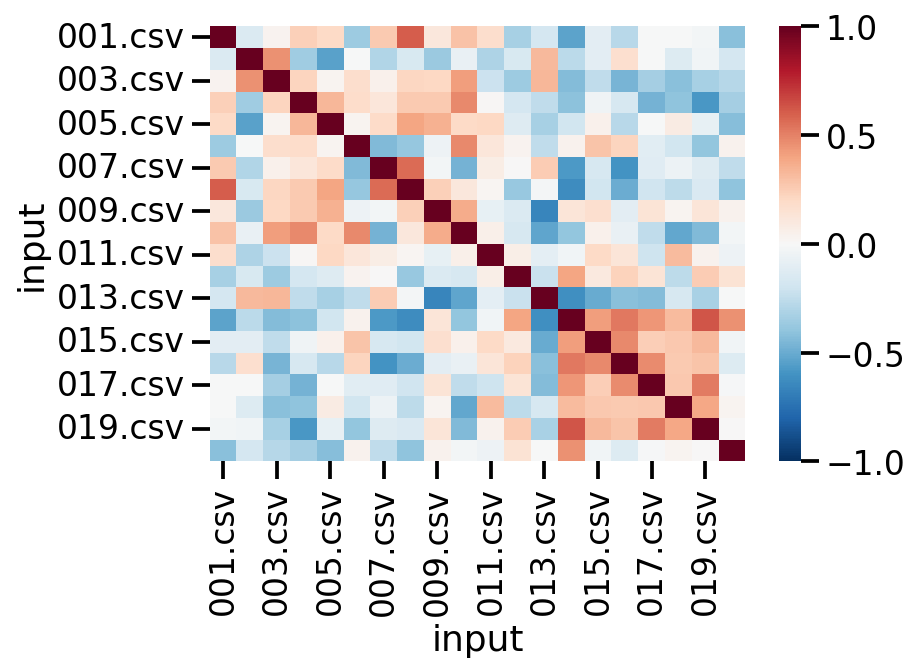

In [56]:
# Set sessions back to unique videos
fex.sessions = fex['input']

# ISC returns a video x video pearson correlation matrix
isc = fex.isc(col = "AU01", method='pearson')
sns.heatmap(isc, center=0, vmin=-1, vmax=1, cmap="RdBu_r");